In [1]:
import os
import math
import numpy as np
import pandas as pd
import statsmodels
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import seaborn

FiguresLoc = os.getcwd() + r'\\Figures\\'

In [2]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.06:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

def zscore(series):
    return (series - series.mean()) / series.std()

                APA      COG     CXO      COP      EOG      MRO       OXY  \
Date                                                                        
2014-01-02  87.9055  38.5336  103.14  82.1583  84.5381  38.4386   98.6179   
2014-01-03  87.9672  38.3115  102.62  82.3702  84.3024  38.0092   98.2711   
2014-01-06  88.7590  38.5638  100.40  82.7234  84.0258  37.9101   98.5653   
2014-01-07  90.3942  39.2402  101.10  82.8529  85.4756  38.4056  100.4042   
2014-01-08  89.1087  39.1191  100.61  82.0523  85.4397  37.8770   99.6056   

                PXD  
Date                 
2014-01-02  177.172  
2014-01-03  176.691  
2014-01-06  174.693  
2014-01-07  175.807  
2014-01-08  176.008  
Cointegrated Pairs => [('COG', 'MRO'), ('CXO', 'EOG')]


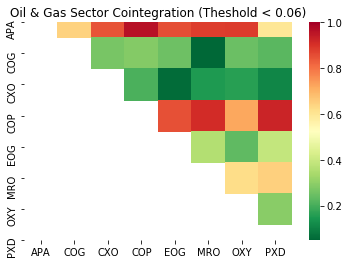

In [3]:
enpStocks = pd.read_csv(os.getcwd() + r'\\E&P_AdjClose.csv', index_col=0)
enpStocks.index = pd.to_datetime(enpStocks.index, format = '%m/%d/%Y')


scores, pvalues, pairs = find_cointegrated_pairs(enpStocks[:1258]);
svm = seaborn.heatmap(pvalues, xticklabels=enpStocks.columns, yticklabels=enpStocks.columns,
                cmap='RdYlGn_r', mask = (pvalues >= 0.99))

print(enpStocks.head())
fig1 = svm.get_figure()
plt.title('Oil & Gas Sector Cointegration (Theshold < 0.06)')
fig1.savefig(FiguresLoc + 'CointegratedHeatMap.png')
print("Cointegrated Pairs => " + str(pairs))

In [4]:
#cointegration and correlation of each pair during formulation period

cog = enpStocks['COG']
mro = enpStocks['MRO']
_, pvalue, _ = coint(cog[:1258], mro[:1258])
print('p-value of the cointegration test: {}'.format(round(pvalue, 4)))
print('COG vs. MRO correlation coefficient: {}'
      .format(round(np.log(cog[:1258]).diff().corr(np.log(mro[:1258]).diff()), 4)))

print('')

cxo = enpStocks['CXO']
eog = enpStocks['EOG']
_, pvalue, _ = coint(cxo[:1258], eog[:1258])
print('p-value of the cointegration test: {}'.format(round(pvalue, 4)))
print('CXO vs. EOG correlation coefficient: {}'
      .format(round(np.log(cxo[:1258]).diff().corr(np.log(eog[:1258]).diff()), 4)))

p-value of the cointegration test: 0.0505
COG vs. MRO correlation coefficient: 0.4591

p-value of the cointegration test: 0.0588
CXO vs. EOG correlation coefficient: 0.8015


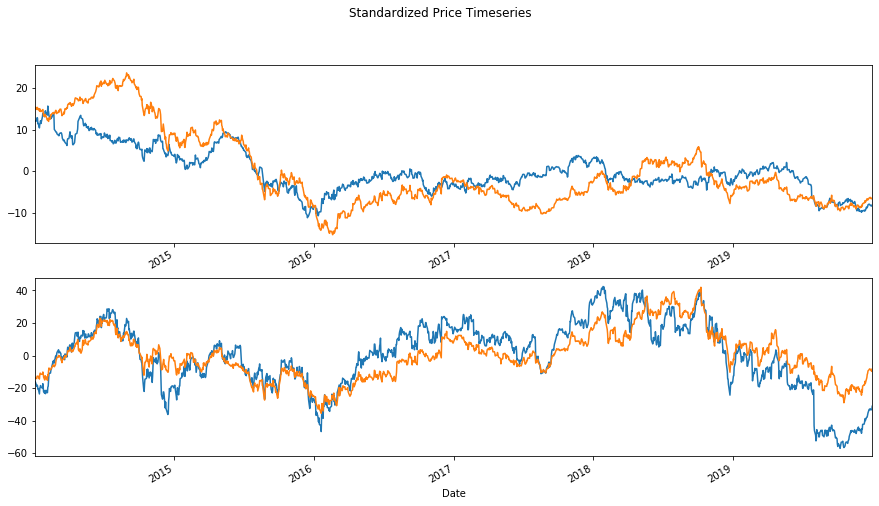

In [5]:
plt.figure(figsize=(15,8))
cog1 = cog - np.mean(cog)
mro1 = mro - np.mean(mro)
plt.suptitle("Standardized Price Timeseries")
plt.subplot(2,1,1)
#plt.title("COG vs MRO")
cog1.plot()
mro1.plot()
plt.xlabel('')

cxo1 = cxo - np.mean(cxo)
eog1 = eog - np.mean(eog)
plt.subplot(2,1,2)
#plt.title("CXO vs EOG")
cxo1.plot()
eog1.plot()
plt.savefig(FiguresLoc + 'StandaridizePriceTimeSeries.png')

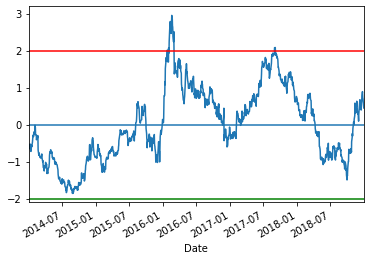

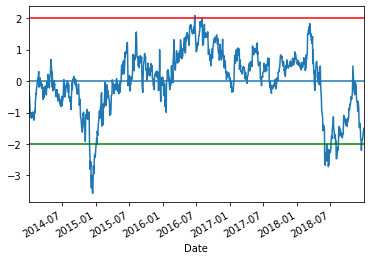

In [6]:
#normalized spreads for each pair during formulation period

spread1 = np.log(cog[:1258]) - np.log(mro[:1258])
zscore(spread1).plot()
plt.axhline(zscore(spread1).mean())
plt.axhline(2, color='red')
plt.axhline(-2, color='green')
plt.show()

print('')

spread2 = np.log(cxo[:1258]) - np.log(eog[:1258])
zscore(spread2).plot()
plt.axhline(zscore(spread2).mean())
plt.axhline(2, color='red')
plt.axhline(-2, color='green')
plt.show()

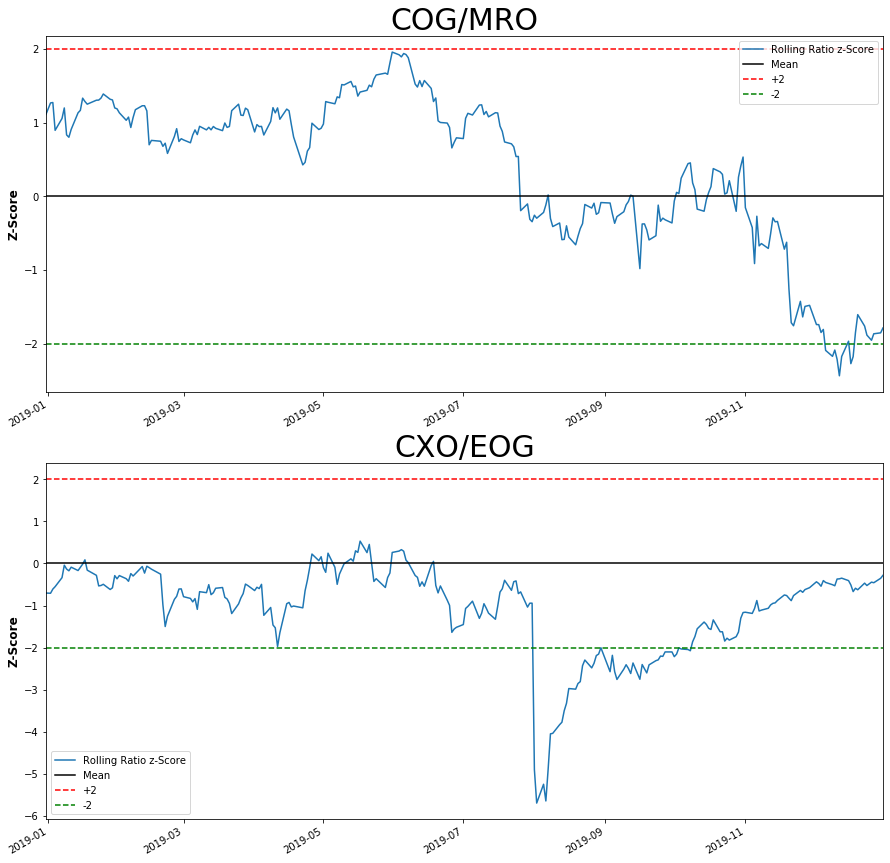

In [7]:
#live trading period signals

spread1_live = np.log(cog[1006:]) - np.log(mro[1006:])
spread_ltma1 = spread1_live.rolling(window=252, center=False).mean()
std_ltma1 = spread1_live.rolling(window=252, center=False).std()
zscore_signal1 = (spread1_live - spread_ltma1) / std_ltma1

spread2_live = np.log(cxo[1006:]) - np.log(eog[1006:])
spread_ltma2 = spread2_live.rolling(window=252, center=False).mean()
std_ltma2 = spread2_live.rolling(window=252, center=False).std()
zscore_signal2 = (spread2_live - spread_ltma2) / std_ltma2

plt.figure(figsize=(15,16))
plt.subplot(2,1,1)
plt.title('COG/MRO', fontsize=30)
zscore_signal1.dropna().plot()
plt.ylabel('Z-Score',fontweight="bold", fontsize=12)
plt.xlabel('')
plt.axhline(0, color='black')
plt.axhline(2.0, color='red', linestyle='--')
plt.axhline(-2.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+2', '-2'])

plt.subplot(2,1,2)
plt.title('CXO/EOG',fontsize=30)
zscore_signal2.dropna().plot()
plt.ylabel('Z-Score',fontweight="bold", fontsize=12)
plt.axhline(0, color='black')
plt.xlabel('')
plt.axhline(2.0, color='red', linestyle='--')
plt.axhline(-2.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+2', '-2'])

plt.savefig(FiguresLoc + 'RollingZScoreTimeseries.png')

In [8]:
# data is pandas dataframe with two columns, each representing stock price
def SimulatePairsAlgo(data, notional, tradeTrigger, rollingWindow = 252):
    stock1 = data.columns[0]
    stock2 = data.columns[1]
    upper = tradeTrigger
    lower = -tradeTrigger
    shares1 = 'Shares ' + stock1
    shares2 = 'Shares ' + stock2
    return1 = 'Daily Ret ' + stock1
    return2 = 'Daily Ret ' + stock2
    
    data['Daily Ret ' + stock1] = np.log(data[stock1]).diff()
    data['Daily Ret ' + stock2] = np.log(data[stock2]).diff()
    data['Spread'] = np.log(data[stock1]) - np.log(data[stock2])
    data['Rolling Avg'] = data['Spread'].rolling(rollingWindow).mean()
    data['Rolling StDev'] = data['Spread'].rolling(rollingWindow).std()
    data['Z-score'] = (data['Spread'] - data['Rolling Avg'])/data['Rolling StDev']
    data['Hedge Ratio'] = data[return1].rolling(rollingWindow-1).corr(data[return2]) * data[return1].rolling(rollingWindow-1).std() / data[return2].rolling(rollingWindow-1).std()

    data[shares1] = (data['Z-score'] > upper).astype(int) * -round(notional/data[stock1],0) + (data['Z-score'] < lower).astype(int) * round(notional/data[stock1],0)
    
    #implement hold position until z-score crosses 0.
    pPos1 = 0
    pZScore = 0
    for index, row in data.iloc[1:].iterrows():
        cZScore = data['Z-score'][index]
        if pZScore * cZScore < 0:
            data[shares1][index] = int(np.abs(cZScore) > tradeTrigger) * data[shares1][index] #in case of large move, put on opposite trade
        elif int(pPos1) != 0:
            data[shares1][index] = pPos1
        pPos1 = data[shares1][index]
        pZScore = cZScore
    
    #base shares2 off shares1 for calculation convienence and daily beta hedge
    data[shares2] = round(-(data[shares1] * data[stock1]) * data['Hedge Ratio'] / data[stock2], 0).fillna(0)
    
    #calc pnl
    pnl1 = "PnL " + stock1
    pnl2 = "PnL " + stock2
    data[pnl1] = ((data[stock1].shift(-1) - data[stock1]) * data[shares1]).shift(1)
    data[pnl2] = ((data[stock2].shift(-1) - data[stock2]) * data[shares2]).shift(1)
    return data

In [9]:
#COG vs. MRO
notional = 10000
stock1 = 'COG'
stock2 = 'MRO'
data = pd.concat([enpStocks[stock1][1006:], enpStocks[stock2][1006:]], axis=1, keys=[stock1, stock2])
tradeTrigger = 2

res = SimulatePairsAlgo(data, notional, tradeTrigger)
print(res.tail())
print("Total PnL " + stock1 + " = " + str(res["PnL " + stock1].sum()))
print("Total PnL " + stock2 + " = " + str(res["PnL " + stock2].sum()))
res.to_csv(os.getcwd() + r'\\SimulationResults1_COG_MRO.csv')

                COG      MRO  Daily Ret COG  Daily Ret MRO    Spread  \
Date                                                                   
2019-12-24  18.3706  16.7309      -0.008564       0.004415  0.093494   
2019-12-26  18.3074  16.8169      -0.003446       0.005127  0.084921   
2019-12-27  18.1389  16.5590      -0.009247      -0.015455  0.091129   
2019-12-30  18.0441  16.4853      -0.005240      -0.004461  0.090350   
2019-12-31  18.3390  16.6818       0.016211       0.011849  0.094712   

            Rolling Avg  Rolling StDev   Z-score  Hedge Ratio  Shares COG  \
Date                                                                        
2019-12-24     0.266925       0.092244 -1.880134     0.239931       590.0   
2019-12-26     0.265859       0.092789 -1.949988     0.239433       590.0   
2019-12-27     0.264821       0.093276 -1.862136     0.236945       590.0   
2019-12-30     0.263860       0.093821 -1.849369     0.240656       590.0   
2019-12-31     0.263094       0.0

In [10]:
#CXO vs. EOG
notional = 10000
stock1 = 'CXO'
stock2 = 'EOG'
data = pd.concat([enpStocks[stock1][1006:], enpStocks[stock2][1006:]], axis=1, keys=[stock1, stock2])
tradeTrigger = 2

res = SimulatePairsAlgo(data, notional, tradeTrigger)
print(res.tail())
print("Total PnL " + stock1 + " = " + str(res["PnL " + stock1].sum()))
print("Total PnL " + stock2 + " = " + str(res["PnL " + stock2].sum()))
res.to_csv(os.getcwd() + r'\\SimulationResults2_CXO_EOG.csv')

                CXO      EOG  Daily Ret CXO  Daily Ret EOG    Spread  \
Date                                                                   
2019-12-24  86.0073  89.9671      -0.001402       0.005144 -0.045012   
2019-12-26  86.5504  89.7954       0.006295      -0.001910 -0.036807   
2019-12-27  85.8564  89.2479      -0.008051      -0.006116 -0.038742   
2019-12-30  86.0173  88.4428       0.001872      -0.009062 -0.027808   
2019-12-31  88.0690  89.9134       0.023572       0.016491 -0.020726   

            Rolling Avg  Rolling StDev   Z-score  Hedge Ratio  Shares CXO  \
Date                                                                        
2019-12-24     0.011526       0.107743 -0.524746     0.954634       131.0   
2019-12-26     0.011050       0.107690 -0.444395     0.954602       131.0   
2019-12-27     0.010547       0.107625 -0.457968     0.955182       131.0   
2019-12-30     0.010071       0.107528 -0.352266     0.954736       131.0   
2019-12-31     0.009571       0.1